In [1]:
import numpy as np
import matplotlib.pyplot as plt
import emcee
from scipy.optimize import minimize
import scipy.optimize as op
import corner
import scipy
from scipy import integrate
from scipy import stats as sst
import scipy.integrate as quad
import pandas as pd
from astropy import units as u
from astropy.coordinates import SkyCoord
from astropy.coordinates import FK5

In [3]:
# Reads the catalog
def readin(cat_name):
    if (datatype == 0):
        # Simulated sample (volume limited)
        glong,glat,dist = np.loadtxt(cat_name, skiprows=1, dtype=float, usecols=(2,3,4),unpack=True)
        return glong,glat,dist
    if (datatype == 1):
        # Real sample (volume limited)
        glong,glat,dist = np.loadtxt(cat_name, skiprows=1, dtype=float, usecols=(1,2,3),unpack=True)
        return glong,glat,dist

# Set the priors
def lnprior(theta):
    if (normlocal == 0 or normlocal == 1):
        rs, zs = theta
        if 100.0 < rs < 5000.0 and 30.0 < zs < 1000.0:
            return 0
        return -np.inf
    else:
        s0, rs, zs = theta
        if 100.0 < rs < 10000.0 and 30.0 < zs < 1500.0 and s0_ml/50. < s0 < s0_ml*50.:
            return 0
    return -np.inf

# Computes likelihood or chi
def model_evaluation(theta, mode, rcyl=None, zcyl=None, densobs1=None, xvals=None, yvals=None, zvals=None):
    
    global normlocal, fullgalaxy, r0, rmax, zmax, rbins, phibins, thetabins, volbin1

    # Normalization based on full Galactic volume
    if normlocal == 0:
        rs, zs = theta
        s0 = fullgalaxy / (4.0 * np.pi * zs * rs * rs)
        s1 = s0
    # Normalization based on volume limited sample    
    elif normlocal == 1:
        rs, zs = theta
        f = lambda y, x: (np.exp(-np.sqrt((x * np.cos(y) + r0) ** 2 + (x * np.sin(y)) ** 2) / rs)) * x
        intcyl = scipy.integrate.dblquad(f, 0.0, rmax, lambda x: 0.0, lambda x: 2 * np.pi, epsabs=1.0e-4, epsrel=1.0e-4)[0]
        intcyl = 2.0 * intcyl * zs * (1 - np.exp(-(zmax / zs)))
        s0 = len(rcyl) / intcyl if mode == "lnlike" else len(xvals) / intcyl
        s1 = s0
    # Normalization as a free parameter
    elif normlocal == 2:
        s0, rs, zs = theta
        s1 = s0

    if mode == "lnlike":
        # Log-likelihood calculation
        if not np.isfinite(np.sum(np.log(s1 * np.exp(-rcyl / rs) * np.exp(-(np.abs(zcyl)) / zs)))):
            return -np.inf
        return np.sum(np.log(s1 * np.exp(-rcyl / rs) * np.exp(-(np.abs(zcyl)) / zs)))

    elif mode == "chi2":
        # Chi-squared calculation
        densmod = np.zeros((rbins, phibins, thetabins))
        densmod = volbin1 * (s1 * np.exp(-xvals / rs) * np.exp(-np.abs(zvals) / zs))
        densmod1 = densmod.flatten()
        densmod2 = densmod1[densobs1 > 4]
        densobs2 = densobs1[densobs1 > 4]
        c2 = np.sum((densobs2 - densmod2) ** 2 / densmod2)
        return -c2

def lnprob(theta, rcyl, zcyl):
    lp = lnprior(theta)
    if not np.isfinite(lp):
        return -np.inf
    lnlike_value = model_evaluation(theta, mode="lnlike", rcyl=rcyl, zcyl=zcyl)
    return lp + lnlike_value

def funcchi2(theta, densobs1, xvals, yvals, zvals):
    lp = lnprior(theta)
    if not np.isfinite(lp):
        return -np.inf
    chi2_value = model_evaluation(theta, mode="chi2", densobs1=densobs1, xvals=xvals, yvals=yvals, zvals=zvals)
    return lp + chi2_value

In [5]:
# Some definitions from input file
params = pd.read_csv('files/mcmc-fit2D_full.pars',header=None,names=['values'],index_col=0,delimiter=',').T

r0, rlim, zmax = params[['Rsun', 'Rlim', 'zmax']].astype(float).values[0]
datatype, normlocal, usechi, bincoords, zbins, rbins, phibins, thetabins = params[['datatype', 'normlocal', 'usechi', 'bincoords', 'zbins', 'rbins', 'phibins', 'thetabins']].astype(int).values[0]

rmax= 795.2986860293433
number of points= 384436
number of points after cylindrical cuts:  263274


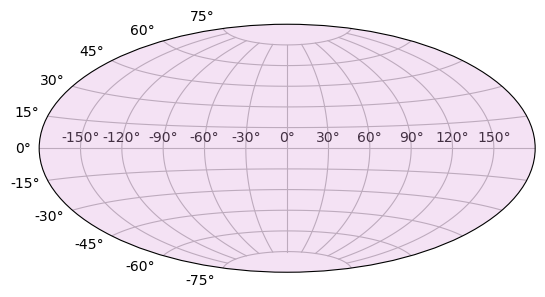

<Figure size 640x480 with 0 Axes>

In [6]:
# Data from GalmodBD (simulation) or real 
glonghelio, glathelio, disthelio = readin('files/galmod_hz250_true_quantities_vol_limited_M9_850pc.dat')

deg2rad=np.pi/180.0

# Calculate ra and dec
gal_coord = SkyCoord(l=glonghelio*u.degree, b=glathelio*u.degree, frame='galactic')
coord_eq=gal_coord.transform_to('fk5')
data = {'ra' : coord_eq.ra*u.degree, 'dec' : coord_eq.dec*u.degree, 'distance_r': coord_eq.distance*u.pc}
coord_eq_final = pd.DataFrame(data, dtype='float')
ra = coord_eq_final['ra'].to_numpy()
ra[ra>180.0]=ra[ra>180.0]-360.0
dec = coord_eq_final['dec'].to_numpy()

# For samples from samples-cut, convert heliocentric l,b to MWcentric ones
xbds = -disthelio*np.cos(glathelio*deg2rad)*np.cos(glonghelio*deg2rad)+r0
ybds = disthelio*np.cos(glathelio*deg2rad)*np.sin(glonghelio*deg2rad)
zbds = np.sin(glathelio*deg2rad)*disthelio

rbds = np.sqrt(xbds**2 + ybds**2 + zbds**2)

# These are r0-centric cylindricals
rcylr0 = np.sqrt((xbds-r0)**2 + ybds**2)
phir0 = glonghelio
rcyl = np.sqrt(xbds**2 + ybds**2)
zcyl = zbds
rmax = np.sqrt(np.abs(rlim**2 - zmax**2))
print('rmax=',rmax)
phimax = 360.0

# These are r0-centric spherical
rsphr0 = np.sqrt((xbds-r0)**2 + ybds**2 + zbds**2)
phir0 = glonghelio
thetar0 = glathelio
thetamax = 90.0

fullgalaxy=len(rbds)
print('number of points=',fullgalaxy)

# These are cylindrical coodinates -- to be used for all sky volume limited samples
if (bincoords == 0):
    # Cut within rmax, zmax from the central point (radial cylindric coordinate r0).
    cylindrical_cut = ((rcylr0 <= rmax) & (np.abs(zcyl) <= zmax) & (np.abs(phir0) <= phimax))
    rcylr0 = rcylr0[cylindrical_cut]
    phir0 = phir0[cylindrical_cut]
    rcyl = rcyl[cylindrical_cut]
    zcyl = zcyl[cylindrical_cut]
    xbds = xbds[cylindrical_cut]
    ybds = ybds[cylindrical_cut]
    zbds = zbds[cylindrical_cut]
    rbds = rbds[cylindrical_cut]
    disthelio = disthelio[cylindrical_cut]
    ra = ra[cylindrical_cut]
    dec = dec[cylindrical_cut]
    print ('number of points after cylindrical cuts: ',len(rcylr0))

    plt.figure()
    plt.subplot(111, projection='aitoff')
    plt.plot(ra, dec, color='plum', markersize=2, alpha=0.3)
    plt.grid(True)
    plt.show()
    plt.clf()

# These are spherical coordinates -- to be used for volume limited samples with angular censorship 
else:
    spherical_cut = ((rsphr0 <= rlim) & (np.abs(thetar0) <= thetamax) & (np.abs(phir0) <= phimax))
    rsphr0 = rsphr0[spherical_cut]
    phir0 = phir0[spherical_cut]
    thetar0 = thetar0[spherical_cut] 
    xbds = xbds[spherical_cut]
    ybds = ybds[spherical_cut]
    zbds = zbds[spherical_cut]
    rbds = rbds[spherical_cut]
    disthelio = disthelio[spherical_cut]
    ra = ra[spherical_cut]
    dec = dec[spherical_cut]
    print ('number of points after spherical cuts: ',len(rsphr0))

    plt.figure()
    plt.subplot(111, projection='aitoff')
    plt.plot(ra, dec, color='plum', markersize=2, alpha=0.3)
    plt.grid(True)
    plt.show()
    plt.clf()

In [7]:
# This function counts number of objects distributed into bins
def count_obs():
    if bincoords == 0:
        ict = 0
        count_obs = np.zeros((int(rbins),int(phibins),int(zbins)))
        for i in range(0,len(disthelio)):
            dist = np.sqrt( (rcylr0[i]*rcylr0[i]) + ((rvalsr0[:,np.newaxis,np.newaxis])**2) - 2.*rcylr0[i]*rvalsr0[:,np.newaxis,np.newaxis] \
                    * (np.cos(np.pi/180.0*(phir0[i]-phivalsr0[np.newaxis,:,np.newaxis]))) + (zcyl[i]-zvalsr0[np.newaxis,np.newaxis,:])**2 )
            ind = np.unravel_index(np.argmin(dist, axis=None), dist.shape)
            jmin = ind[0]
            kmin = ind[1]
            lmin = ind[2]
            count_obs[jmin,kmin,lmin] = count_obs[jmin,kmin,lmin] + 1.
            ict = ict+1
      
    elif bincoords == 1:
        ict = 0
        count_obs = np.zeros((int(rbins),int(phibins),int(thetabins)))
        for i in range(0,len(disthelio)):
            dist = np.sqrt( (rsphr0[i]*rsphr0[i]) + ((rvalsr0[:,np.newaxis,np.newaxis])**2) - 2.*rsphr0[i]*rvalsr0[:,np.newaxis,np.newaxis] \
                        * ((np.cos(np.pi/180.0*thetar0[i])) * (np.cos(np.pi/180.0*thetavalsr0[np.newaxis,np.newaxis,:]))  \
                        * (np.cos(np.pi/180.0*(phir0[i]-phivalsr0[np.newaxis,:,np.newaxis]))) + (np.sin(np.pi/180.0*thetar0[i])) \
                        * (np.sin(np.pi/180.0*thetavalsr0)[np.newaxis,np.newaxis,:])))
            ind = np.unravel_index(np.argmin(dist, axis=None), dist.shape)
            jmin = ind[0]
            kmin = ind[1]
            lmin = ind[2]
            count_obs[jmin,kmin,lmin] = count_obs[jmin,kmin,lmin] + 1.
            ict = ict+1

    return(count_obs)

In [8]:
# Normalization based on volume limited sample
if normlocal == 1:    
    zstep = 2.*zmax/zbins
    zvalsr0 = np.arange(-zmax+zstep/2.,+zmax-zstep/2.+0.001,zstep)
    rstep = rmax/rbins
    rvalsr0 = np.arange(rstep/2.,rmax-rstep/2.+0.001,rstep)
    phistep = phimax/phibins
    phivalsr0 = np.arange(phistep/2.,+phimax-phistep/2.+0.00001,phistep)
        
    volbin = rvalsr0*(np.pi*phistep/180.0)*rstep*zstep
    volbin1 = volbin[:,np.newaxis,np.newaxis]

    densobs = count_obs()   
    
elif normlocal == 2:
    thetastep = 2*thetamax/thetabins
    thetavalsr0 = np.arange(-thetamax+thetastep/2.,+thetamax-thetastep/2.+0.00001,thetastep)
    rstep = rlim/rbins
    rvalsr0 = np.arange(rstep/2.,rlim-rstep/2.+0.001,rstep)
    phistep = phimax/phibins
    phivalsr0 = np.arange(phistep/2.,+phimax-phistep/2.+0.00001,phistep)
    
    # The expression for the volume element below applies only to small volumes centered on the sun
    volbin = (rvalsr0[:,np.newaxis]**2)*np.cos(np.pi/180.0*thetavalsr0[np.newaxis,:])*(np.pi*phistep/180.0)*(np.pi*thetastep/180.0)*rstep
    volbin1 = volbin[:,np.newaxis,:]

    densobs = count_obs()   

densobs1 = densobs.flatten()
for_chi = (densobs1 > 4)
print('tot num bins:',len(densobs1),'number of usable bins:',len(densobs1[for_chi]))

tot num bins: 2352 number of usable bins: 2329


In [9]:
# Initial guesses for scale length and height
rs_ml = 2000.
zs_ml = 300.

if normlocal == 0 or normlocal == 1:    
    result = rs_ml, zs_ml
    ndim, nwalkers = 2, 100
    
    pos = [result + 1e-4*np.random.randn(ndim) for j in range(nwalkers)]
    
    if usechi == 0:
        sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob, args=(rcyl, zcyl))
    else:
        # Convert bin centers from r0-centric cylindrical to MWcentric cylindricals
        rvals = np.sqrt( ( r0 + rvalsr0[:,np.newaxis,np.newaxis] * (np.cos((phivalsr0[np.newaxis,:,np.newaxis]-180.0)*np.pi/180.)) )**2 \
            +( rvalsr0[:,np.newaxis,np.newaxis] * (np.sin((phivalsr0[np.newaxis,:,np.newaxis]-180.0)*np.pi/180.)) )**2 ) \
            + zvalsr0[np.newaxis,np.newaxis,:] - zvalsr0[np.newaxis,np.newaxis,:]
        zvals = zvalsr0[np.newaxis,np.newaxis,:] + rvals - rvals
        phivals = phivalsr0[np.newaxis,:,np.newaxis] + rvals - rvals
        sampler = emcee.EnsembleSampler(nwalkers, ndim, funcchi2, args=(densobs1, rvals, phivals, zvals))
    
elif normlocal == 2:
    s0_ml = (np.exp(r0/rs_ml)*(len(rbds)/(rlim**3)))
    s0_ml = 8*s0_ml # The DES footprint covers about 1/8 of the full sky (just an example)
    result = s0_ml, rs_ml, zs_ml
    print('s0_ml, rs_ml, zs_ml:', result)
    ndim, nwalkers = 3, 100
    
    pos = [result + 1e-4*np.random.randn(ndim) for j in range(nwalkers)]

    # Convert bin centers from r0-centric spherical to MWcentric cylindricals
    rvals = np.sqrt( ( r0 + rvalsr0[:,np.newaxis,np.newaxis] * (np.cos(thetavalsr0[np.newaxis,np.newaxis,:]*(np.pi/180.))) \
        * (np.cos((phivalsr0[np.newaxis,:,np.newaxis]-180.)*(np.pi/180.))) ) **2 + ( rvalsr0[:,np.newaxis,np.newaxis] \
        * (np.cos(thetavalsr0[np.newaxis,np.newaxis,:]*(np.pi/180.))) * (np.sin((phivalsr0[np.newaxis,:,np.newaxis]-180.)*(np.pi/180.))) )**2 ) 
    phivals = phivalsr0[np.newaxis,:,np.newaxis] + rvals - rvals
    zvals = rvalsr0[:,np.newaxis,np.newaxis] * (np.sin(thetavalsr0[np.newaxis,np.newaxis,:]*np.pi/180.)) - rvals + rvals
    sampler = emcee.EnsembleSampler(nwalkers, ndim, funcchi2, args=(densobs1, rvals, phivals, zvals))

    
print('Some burn-in steps in the chain to let the walkers explore the parameter space a bit and get settled into the maximum of the density!')
state = sampler.run_mcmc(pos, 100)
sampler.reset()

Some burn-in steps in the chain to let the walkers explore the parameter space a bit and get settled into the maximum of the density!


In [10]:
sampler.run_mcmc(state,600,progress=True)
samples = sampler.chain[:, 200:, :].reshape((-1, ndim))

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 600/600 [06:09<00:00,  1.63it/s]


Mean acceptance fraction: 0.713
Final fit values Rs, zs: 2557.216484814887 283.0135599250908
Fit errors: 33.88913276771018 30.629364375545265 1.8778629195962253 1.8381745174222033


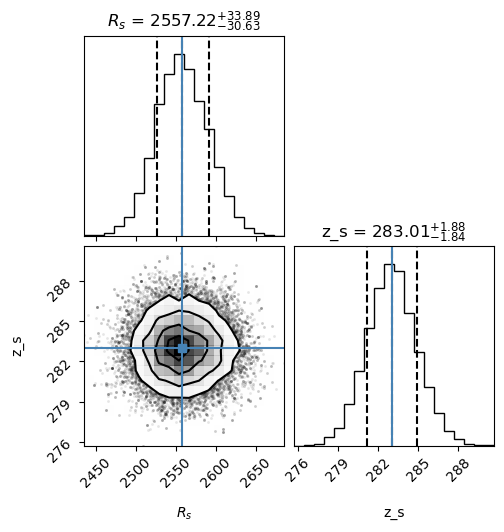

Lets check the positions of each walker as a function of the number of steps in the chain:


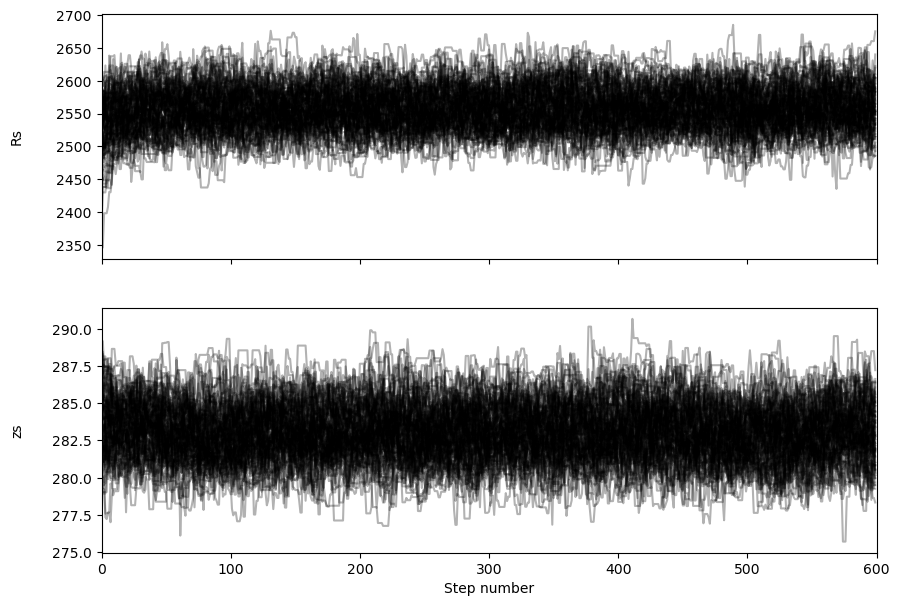

In [11]:
print('Mean acceptance fraction: {0:.3f}'.format(np.mean(sampler.acceptance_fraction)))

if normlocal == 1 or normlocal == 0:
    rs_mcmc, zs_mcmc = map(lambda v: (v[1], v[2]-v[1], v[1]-v[0]), zip(*np.percentile(samples, [16, 50, 84],axis=0)))
    print ("Final fit values Rs, zs:",rs_mcmc[0],zs_mcmc[0])
    print ("Fit errors:", rs_mcmc[1],rs_mcmc[2],zs_mcmc[1],zs_mcmc[2]) 
 
    fig = corner.corner(samples, labels=["$R_s$", "z_s"], truths=[rs_mcmc[0], zs_mcmc[0]], quantiles=[0.16, 0.5, 0.84], show_titles=True, plot_contours=True)
    plt.show()
    
    print('Lets check the positions of each walker as a function of the number of steps in the chain:')
    fig, axes = plt.subplots(2, figsize=(10, 7), sharex=True)
    sample0 = sampler.get_chain()
    labels = ['Rs', 'zs']
    for i in range(ndim):
        ax = axes[i]
        ax.plot(sample0[:, :, i], "k", alpha=0.3)
        ax.set_xlim(0, len(sample0))
        ax.set_ylabel(labels[i])
        ax.yaxis.set_label_coords(-0.1, 0.5)

    axes[-1].set_xlabel("Step number");
    
elif normlocal == 2: 
    s0_mcmc, rs_mcmc, zs_mcmc = map(lambda v: (v[1], v[2]-v[1], v[1]-v[0]), zip(*np.percentile(samples, [16, 50, 84],axis=0)))
    print ("Final fit values s0, Rs, zs:",s0_mcmc[0],rs_mcmc[0],zs_mcmc[0])
    print ("Fit errors:", s0_mcmc[1], s0_mcmc[2], rs_mcmc[1],rs_mcmc[2],zs_mcmc[1],zs_mcmc[2]) 
 
    fig = corner.corner(samples, labels=["$n$", "$R_{s}$", "$z_{s}$"], truths=[s0_mcmc[0], rs_mcmc[0], zs_mcmc[0]], quantiles=[0.16, 0.5, 0.84], show_titles=True, plot_contours=True)
    plt.show()
    
    print('Lets check the positions of each walker as a function of the number of steps in the chain:')
    fig, axes = plt.subplots(3, figsize=(10, 7), sharex=True)
    sample0 = sampler.get_chain()
    labels = ['$s_{0}$', '$R_{s}$', '$z_{s}$']
    for i in range(ndim):
        ax = axes[i]
        ax.plot(sample0[:, :, i], "k", alpha=0.3)
        ax.set_xlim(0, len(sample0))
        ax.set_ylabel(labels[i])
        ax.yaxis.set_label_coords(-0.1, 0.5)

    axes[-1].set_xlabel("Step number");